**HDS 5230 High Performance Computing**

**Final Exam - Progamming Part**


*Miao Cai*

The big goal is to use the provided dataset on health insurance charges to create a model that predicts charges as accurately as possible, based on the patient traits of age, sex, bmi, children, smoker, and region. As you generate this model, you should perform and document initial data quality checks, exploratory data analysis, and all of the models you try to fit.

General components:

- Brief data summary for EDA summarizing the model input variables

- Univariate summary of the model output (cost)

- Pick a loss function and explain why you think it is a reasonable choice.

- Implement a cross validation scheme. Explain how you did this in your report.

- For the machine learning sections, implement at least the following models:

    + A few different models using H2O (random forest, gbm, regularized regression, Auto-ML)

    + At least 2 different architectures of neural networks using keras and tensorflow, implementing some form of regularization

- A summary of the training error versus generalization error to ensure you didn’t overfit the data.

- Estimate the generalization error in your final model. Clearly state how you chose to estimate the generalization error, as well as what final expected value is. This is based on your choice of loss function

# Introduction

The big goal is to use the provided dataset on health insurance charges to create a model that predicts charges as accurately as possible, based on the patient traits of age, sex, bmi, children, smoker, and region. As you generate this model, you should perform and document initial data quality checks, exploratory data analysis, and all of the models you try to fit.

# Methods summary

All the data cleaning, visualization, and modeling were conducted in Python, and this reported was wrote in jupyternotebook. The Python session and package version information is shown below.

In [29]:
import os
import sys
import pathlib
from tableone import TableOne
import pandas as pd
import numpy as np
import seaborn as sns
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

print(sys.version)
print("Pandas version: {0}".format(pd.__version__))
print("Numpy version:{0}".format(np.__version__))
print("Seaborn version:{0}".format(sns.__version__))
print("h2o version:{0}".format(h2o.__version__))
print("My working directory:\n" + os.getcwd())

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Pandas version: 0.24.2
Numpy version:1.16.2
Seaborn version:0.9.0
h2o version:3.24.0.1
My working directory:
C:\Users\miaocai\Dropbox\@2018 SPRING HDS5230 High performance computing\hds5230Homework\Final exam


### Loss function

I pick the loss function as the mean absolute error (MAE). I chose this loss function since the outcome variable charges are highly right-skewed. Using the most commonly used mean square error (MSE) will not be as robust as MAE since the error will be squared, which is strongly influenced by outliers.

### Initiate h2o and read data

In [5]:
h2o.init(ip='localhost', port=54321, nthreads=-1, max_mem_size='2G')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from C:\Users\miaocai\.conda\envs\p36ws\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\miaocai\AppData\Local\Temp\tmp1s5x382w
  JVM stdout: C:\Users\miaocai\AppData\Local\Temp\tmp1s5x382w\h2o_miaocai_started_from_python.out
  JVM stderr: C:\Users\miaocai\AppData\Local\Temp\tmp1s5x382w\h2o_miaocai_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,1 month and 8 days
H2O cluster name:,H2O_from_python_miaocai_xb5oj2
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [25]:
d0 = h2o.import_file("insurance.csv")
d0

Parse progress: |█████████████████████████████████████████████████████████| 100%


age,sex,bmi,children,smoker,region,charges
19,female,27.9,0,yes,southwest,16884.9
18,male,33.77,1,no,southeast,1725.55
28,male,33,3,no,southeast,4449.46
33,male,22.705,0,no,northwest,21984.5
32,male,28.88,0,no,northwest,3866.86
31,female,25.74,0,no,southeast,3756.62
46,female,33.44,1,no,southeast,8240.59
37,female,27.74,3,no,northwest,7281.51
37,male,29.83,2,no,northeast,6406.41
60,female,25.84,0,no,northwest,28923.1


In [26]:
print("The shape of the DataFrame is:")
print(d0.shape)
list(zip(d0.nacnt(), d0.names))

The shape of the DataFrame is:
(1338, 7)


[(0.0, 'age'),
 (0.0, 'sex'),
 (0.0, 'bmi'),
 (0.0, 'children'),
 (0.0, 'smoker'),
 (0.0, 'region'),
 (0.0, 'charges')]

After reading the .csv file by using h2o, I found that there are no missing values in the data, which is great! 

### Split into train/validation/testing splits

We then need to convert some categorical variables into factors, and split the data into train, test, and validation sets.

In [27]:
d0[['sex', 'smoker', 'region']] = d0[['sex', 'smoker', 'region']].asfactor()
dtrain, dtest, dvalid = \
    d0.split_frame([0.7, 0.15], seed = 666)

# Results

## Summary statistics of model input variables

In [16]:
d = pd.read_csv("insurance.csv")
col_types = d.dtypes.to_dict()
col_types['age'] = 'float64'
d = pd.read_csv("insurance.csv", dtype=col_types)

overall_table = TableOne(
    d, columns = ['age', 'bmi', 'children', 'smoker', 'region'], 
    categorical = ['children', 'smoker', 'region'], 
    groupby = 'sex', label_suffix=True, pval = True)
overall_table

Grouped by sex                                                    
                                  isnull       female         male   pval              ptest
variable        level                                                                       
n                                                 662          676                          
age, mean (SD)                         0  39.5 (14.1)  38.9 (14.1)  0.446  Two Sample T-test
bmi, mean (SD)                         0   30.4 (6.0)   30.9 (6.1)  0.090  Two Sample T-test
children, n (%) 0                      0   289 (43.7)   285 (42.2)  0.981        Chi-squared
                1                          158 (23.9)   166 (24.6)                          
                2                          119 (18.0)   121 (17.9)                          
                3                           77 (11.6)    80 (11.8)                          
                4                            11 (1.7)     14 (2.1)                          
                5                             8 (1.2)     10 (1.5)                          
smoker, n (%)   no                     0   547 (82.6)   517 (76.5)  0.007        Chi-squared
                yes                        115 (17.4)   159 (23.5)                          
region, n (%)   northeast              0   161 (24.3)   163 (24.1)  0.933        Chi-squared
                northwest                  164 (24.8)   161 (23.8)                          
                southeast                  175 (26.4)   189 (28.0)                          
                southwest                  162 (24.5)   163 (24.1)                          
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: age.
[2] Warning, test for normality reports non-normal distributions for: age.

## Descriptive analysis of the outcome variable charges

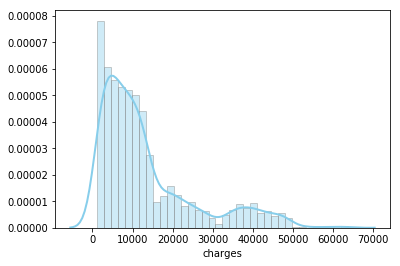

In [70]:
sns.distplot(d['charges'], hist=True, kde=True, 
             bins=int(180/5), color = 'skyblue', 
             hist_kws={'edgecolor':'grey'},
             kde_kws={'linewidth': 2})

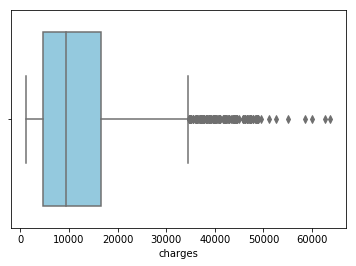

In [72]:
sns.boxplot(d['charges'], color = 'skyblue')

In [74]:
d['charges'].describe()

count    1338.00
mean    13270.42
std     12110.01
min      1121.87
25%      4740.29
50%      9382.03
75%     16639.91
max     63770.43
Name: charges, dtype: float64

## Cross-validation

Here I use the `H2OGeneralizedLinearEstimator` module in `h2o` package to perform cross-validation. I set the number of cross-validation as 5 by `nfolds=5`, in which 6 models will be built. The first 5 models (cross-validation models) are built on 80% of the training data, and a different 20% is held out for each of the 5 models. Then the main model is built on 100% of the training data.

In [38]:
target_var = 'charges'
input_var = ['age', 'sex', 'bmi', 
             'children', 'smoker', 'region']
glm_mod0 = \
    H2OGeneralizedLinearEstimator(model_id = 'd_glm_0',
                                  family = 'gaussian',
                                  nfolds = 5,
                                  seed = 123)
glm_mod0.train(x = input_var, 
               y = target_var, 
               training_frame = d0)
glm_mod0.show()

glm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  d_glm_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 125728309.44330035
RMSE: 11212.863570172445
MAE: 8471.397911142334
RMSLE: 0.9331157151413909
R^2: 0.14203674139265943
Mean Residual Deviance: 125728309.44330035
Null degrees of freedom: 1337
Residual degrees of freedom: 1326
Null deviance: 196074221532.74988
Residual deviance: 168224478035.13586
AIC: 28776.289622947068

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 129830749.84711617
RMSE: 11394.32972346843
MAE: 8600.97548619905
RMSLE: 0.9464119017196216
R^2: 0.11404190751089327
Mean Residual Deviance: 129830749.84711617
Null degrees of freedom: 1337
Residual degrees of freedom: 1326
Null deviance: 196632689167.88873
Residual deviance: 173713543295.44144
AIC: 28819.25062652632
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,8592.547,295.31107,8582.3125,7818.5264,8785.108,8714.119,9062.668
mean_residual_deviance,129275808.0000000,12568459.0000000,122953088.0000000,102175632.0000000,153850944.0000000,124694504.0000000,142704864.0000000
mse,129275808.0000000,12568459.0000000,122953088.0000000,102175632.0000000,153850944.0000000,124694504.0000000,142704864.0000000
null_deviance,39326540000.0000000,4538068000.0000000,37283930000.0000000,29694271500.0000000,49030697000.0000000,37774651000.0000000,42849141000.0000000
r2,0.1105586,0.0058998,0.1174623,0.1147653,0.1004910,0.1195456,0.1005287
residual_deviance,34742710000.0000000,4171281920.0000000,32705521700.0000000,26156961800.0000000,43847520000.0000000,33044043800.0000000,37959496000.0000000
rmse,11342.573,557.5985,11088.422,10108.196,12403.667,11166.67,11945.914
rmsle,0.9458453,0.0343231,0.9813831,0.9140743,0.8841538,1.0196682,0.9299473


Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2019-05-09 23:32:00,0.000 sec,0,196074221568.3671875,146542766.4935480


## Machine learning

### Gradient boost machine


### Regularized regression




# Conclusion